In [1]:
# librairies

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.dataframe as dd
import dask.array as da

In [2]:
# open the combined_square_storm_dataset.nc file

sq = xr.open_dataset('combined_square_storm_dataset.nc')
sq

<xarray.Dataset>
Dimensions:     (point: 158, coordinate: 4, storm: 96)
Coordinates:
  * point       (point) int32 0 1 2 3 4 5 6 7 ... 151 152 153 154 155 156 157
  * coordinate  (coordinate) int32 0 1 2 3
Dimensions without coordinates: storm
Data variables:
    tc_irad     (storm, point, coordinate) float64 ...

Coordinates:
  * point       (point) int32 0 1 2 3 4 5 6 7 ... 151 152 153 154 155 156 157
  * coordinate  (coordinate) int32 0 1 2 3


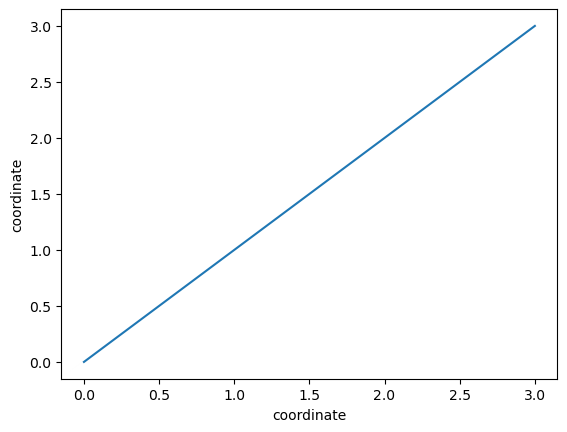

In [3]:
# extract the squares of the first storm

sq1 = sq.sel(storm=5)
sq1
print(sq1.coords)
sq1.coords['coordinate'].plot()
plt.show()

# the combined_square_storm_dataset.nc file does not contain the square coordinates, so let's switch with the .txt file

In [67]:
# opening the first storm tracks saved as tc_irad_1.txt

head = ['lon_east', 'lon_west', 'lat_south', 'lat_north']

tc_irad_1 = pd.read_csv('tc_irad/tc_irad_1.txt', sep=',')
tc_irad_test = tc_irad_1.copy()
tc_irad_1.columns = head

In [5]:
# creating the coordinates of the squares

lon_east = tc_irad_1['lon_east']
lon_west = tc_irad_1['lon_west']
lat_south = tc_irad_1['lat_south']
lat_north = tc_irad_1['lat_north']

In [6]:
# path to one variable 

local_path = '/Users/fabienaugsburger/myCloud/Unil/Master/Thesis/Datasets/Curnagl/ERA5_1990_2m_dewpoint_temperature.nc'

dew_point_xr = xr.open_dataset(local_path)
dew_point_xr

In [64]:
# slice the time dimension

dates = pd.read_csv('storms_start_end.csv', sep=',')

start_first = dates['start_date'][0]
end_first = dates['end_date'][0]

dew_point_xr = dew_point_xr.sel(time=slice(start_first, end_first))
dew_point_xr

# append the time of the dew_point_xr in the tc_irad_1 dataframe

time = dew_point_xr['time']
time = time.to_dataframe()

tc_irad_1['time'] = time

ValueError: Columns must be same length as key

In [12]:
# convert to a dataframe

dew_point = dew_point_xr.to_dataframe()

In [13]:
# select indexes of the dew_point dataframe

# extraction of the variable
dew_point['lon'] = dew_point.index.get_level_values('longitude')
dew_point['lat'] = dew_point.index.get_level_values('latitude')
dew_point['time'] = dew_point.index.get_level_values('time')

'''
dew_point = dew_point.reset_index()
dew_point = dew_point.set_index(['latitude', 'longitude'])
dew_point = dew_point.sort_index()
dew_point'''

"\ndew_point = dew_point.reset_index()\ndew_point = dew_point.set_index(['latitude', 'longitude'])\ndew_point = dew_point.sort_index()\ndew_point"

In [14]:
print(lon_west[0], lon_east[0], lat_south[0], lat_north[0])

297.195404 289.195404 37.979839 45.979839


In [15]:
# rounding the coordinates to the 0.25 degree grid

r_lat_north = [round(coord / 0.25) * 0.25 for coord in lat_north]
r_lat_south = [round(coord / 0.25) * 0.25 for coord in lat_south]
r_lon_east = [round(coord / 0.25) * 0.25 for coord in lon_east]
r_lon_west = [round(coord / 0.25) * 0.25 for coord in lon_west]

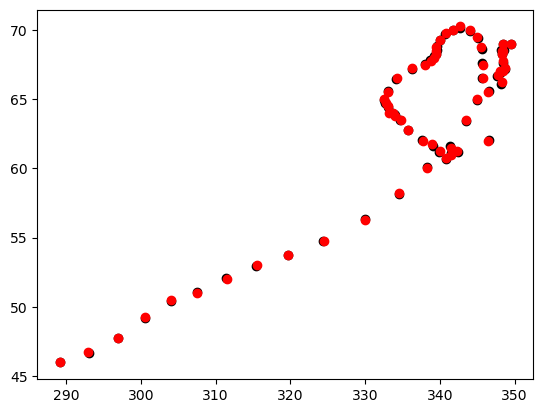

-0.00763475409836143 -0.0034969672131141957 degrees
-0.8499008262295943 -0.3892823901638722 km


In [16]:
# compare the rounded coordinates with the original ones on a map 

plt.plot(lon_east, lat_north, 'o', color='black')
plt.plot(r_lon_east, r_lat_north, 'o', color='red')
plt.show()

mean_diff_lat = np.mean(np.array(lat_north) - np.array(r_lat_north))
mean_diff_lon = np.mean(np.array(lon_east) - np.array(r_lon_east))

print(mean_diff_lat, mean_diff_lon, "degrees")

mean_diff_lat_km = mean_diff_lat * 111.32
mean_diff_lon_km = mean_diff_lon * 111.32

print(mean_diff_lat_km, mean_diff_lon_km, "km")

In [20]:
# create a dataframe with the rounded coordinates

r_tc_irad_1 = pd.DataFrame({'lon_east': r_lon_east, 'lon_west': r_lon_west, 'lat_south': r_lat_south, 'lat_north': r_lat_north})

In [48]:
def extract_coordinates(main_df, square_df):
    # Initialize empty lists to store selected 'lon' and 'lat'
    selected_lon = []
    selected_lat = []

    # Loop through rows of the main DataFrame
    for index, row in main_df.iterrows():
        time = row['time']
        lon = row['lon']
        lat = row['lat']

        # Find the corresponding square for the given time
        square_info = square_df[square_df['time'] == time]

        if not square_info.empty:
            # Check if the coordinates (lon, lat) fall within the square
            for _, square_row in square_info.iterrows():
                if (
                    square_row['lon_west'] <= lon <= square_row['lon_east']
                    and square_row['lat_south'] <= lat <= square_row['lat_north']
                ):
                    selected_lon.append(lon)
                    selected_lat.append(lat)
                    break  # Break the loop if the coordinates are found within a square

    # Create a new DataFrame with selected 'lon' and 'lat'
    result_df = pd.DataFrame({'lon': selected_lon, 'lat': selected_lat})

    return result_df

# Example usage:
# Assuming main_df and square_df are your DataFrames
# result_coordinates = extract_coordinates(main_df, square_df)

In [23]:
# select the r_lat_north, r_lat_south, r_lon_east, r_lon_west coordinates in the dew_point dataframe

for i in range(1, len(dew_point)):
    for j in range(1, len(r_tc_irad_1)):
        temp_df = dew_point[(dew_point['time']==dew_point['time'][j])]
        print(j,'j')
    print(i,'i')